### ASSIST tests: (3666) Holman integrations

TEST - aryaakmal fork, jupyter_test branch

Here we demonstrate the integration of (3666) Holman, a main belt asteroid,using ASSIST.  

ASSIST is a set of python-wrapped C functions that implement an ephemeris quality-integrator that have been compiled into a library.  That library is imported with the assist.py package.

The primary function in assist.py is 'integration_function', which integrates massless test particles in the field of the Sun, planets, Moon, and 16 massive asteroids.  It also includes the J2, J3, and J4 gravitational harmonics of the Earth, the J2 gravitational harmonic of the Sun, and the solar GR terms (using the PPN formulation).  

The positions of the massive bodies come from two binary files, both from JPL.  The first is for the Sun, planets, and Moon, with the latest DE441 ephemeris. The other is for the asteroids, corresponding to DE441.  

The coordinate frame and units are not flexible, currently.  The coordinate frame is the equatorial ICRF, which is the native coordinate system for the JPL binary files.  Note that this is equatorial rather than ecliptic.  In addition, the native coordinates are barycentric, rather than heliocentric. 

For units we use solar masses, au, and days.  The independent time coordinate is TDB in Julian days.

The underlying numerical integrator is IAS15 (Rein & Liu 2015), a 15th order predictor-corrector integrator with an adaptive step-size.  Each time step involves eight sub-steps.  We have modified the integrator to output the state at each of the sub-steps in order to support interpolation of the output.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import ctypes
import importlib

import spiceypy as spice

import pkg_resources
import sys
sys.path.append(r'/Users/mholman/assist')
import assist

jd_ref = spice.j2000()

plt.rc('text', usetex = True)

au_km = 149597870.700

In [2]:
# This cell defines the initial conditions we have used for these integrations.
# The dynamical state currently available on Horizons might be slightly different because additional
# observations have been incorporated into the orbital solution.
#
# DE441
# (3666) Holman
#2458849.500000000 = A.D. 2020-Jan-01 00:00:00.0000 TDB 
row = [3.338875348598862E+00, -9.176518412197102E-01, -5.038590741719294E-01,
     2.805663364339457E-03, 7.550408665778840E-03, 2.980028207875623E-03]

In [4]:
%%time
tstart, tstep = 2458849.5-jd_ref, 20.0

instates = np.array([row])
n_var = 6
n_particles = 7
geocentric = 0

invar_part = np.zeros(6, dtype=int)
invar = np.identity(6)

scale = 1e-8
instatesp = np.array([row]*6)+scale*invar
instates=np.vstack([instates, instatesp])

# Turn off the non-grav terms
part_params = None
var_part_params = None

nsubsteps = 10
hg = np.arange(0, 1.1, 0.1, dtype=np.double)


with open('holman_sb.txt') as file:
    file.readline()
    file.readline()
    file.readline()
    for line in file:
        trange = float(line.split()[0])
        vec = np.array(line.rstrip().split()[-3:], dtype=np.double)
        tend = tstart + trange
        times, states, var, var_ng, status = assist.integration_function(tstart, tend, tstep, geocentric, 
                                                                       n_particles, instates, part_params, n_var, invar_part, invar, var_part_params, hg,
                                                                       nsubsteps=nsubsteps)
        GMsun, sun = assist.all_ephem(0, jd_ref, times[-1])
        holman_sb=vec/au_km + sun[0:3]
        print(trange, np.linalg.norm((holman_sb-states[-1][0][0:3])*au_km*1e3))

        

        

10.0 0.00026677522498267736
100.0 0.0009504218857056121
1000.0 0.09269397037419533
10000.0 3.696653221476527
CPU times: user 4.87 s, sys: 295 ms, total: 5.17 s
Wall time: 5.17 s


In [6]:
%%time
tstart, tstep = 2458849.5-jd_ref, 20.0

instates = np.array([row])
n_var = 6
n_particles = 7
geocentric = 0

invar_part = np.zeros(6, dtype=int)
invar = np.identity(6)

scale = 1e-8
instatesp = np.array([row]*6)+scale*invar
instates=np.vstack([instates, instatesp])

# Turn off the non-grav terms
part_params = None
var_part_params = None

nsubsteps = 10
hg = np.arange(0, 1.1, 0.1, dtype=np.double)

trange = 10000
tend = tstart + trange
times, states, var, var_ng, status = assist.integration_function(tstart, tend, tstep, geocentric, 
                                                                    n_particles, instates, part_params, n_var, invar_part, invar, var_part_params, hg,
                                                                    nsubsteps=nsubsteps)
        

CPU times: user 4.28 s, sys: 248 ms, total: 4.53 s
Wall time: 4.53 s


Below is a plot of the overall step-size as a function of elapsed integration time.  (The sub-steps are smaller).  A rough periodicity on the ~2000 day asteroid orbital period is evident.

Text(0, 0.5, 'step-size (days)')

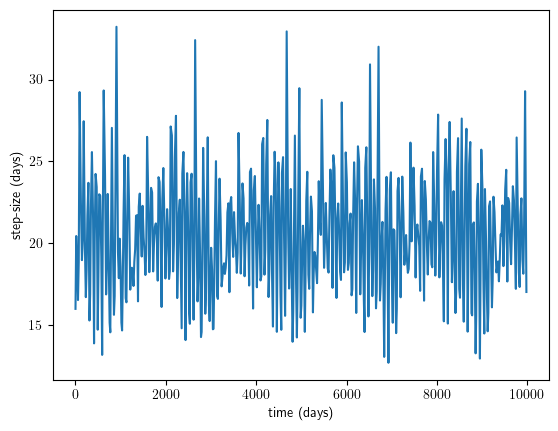

In [7]:
t=(times-times[0])[::8]
dt=t[1:]-t[:-1]

plt.plot(t[:-1], dt)
plt.xlabel("time (days)")
plt.ylabel("step-size (days)")
plt.savefig('step_sizes.pdf')

And here is a histogram of the step-sizes.  Most are 15-25 days.

Text(0, 0.5, 'N')

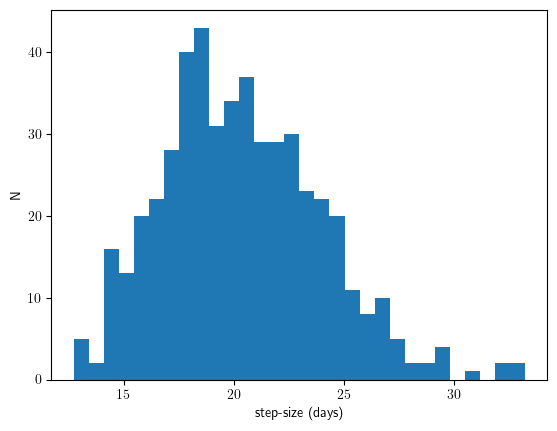

In [8]:
_=plt.hist(dt,bins=30)
plt.xlabel("step-size (days)")
plt.ylabel("N")
plt.savefig('step_size_hist.pdf')

Here are the xyz values as a function of time.  The coordinate system is equatorial, so the z component is not nearly zero.

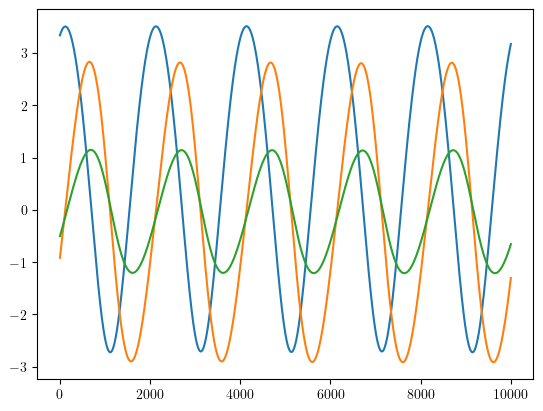

In [9]:
for i in range(3):
    plt.plot(times-times[0], states[:,0,i])
    plt.savefig('xyz_vs_t.pdf')

The differences between the ASSIST-integrated states and those from Horizons are ~1km and ~3km after 4,000 and 10,000 days, respectively.

Here is a top-down view of the orbit.

Text(0, 0.5, 'y (AU)')

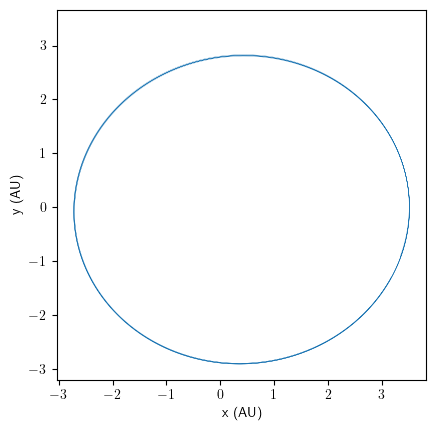

In [10]:
plt.plot(states[:,0,0], states[:,0,1], linewidth=0.2)
plt.axis('square')
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
plt.savefig('xy.pdf')

What about 'var' in the output?  It looks like there are extra particles.  In fact, for each actual particle production_integration_function_wrapper generates six "variational particles" or tangent vectors.  These are vectors with the same dimensionality as an actual particle state, but they are the result of integrating the linearized tangent equations, or variational equations.  There is one variational particle for each of the six dimensions, with the initial state being a unit vector.

One way to think of the variational equations is to consider two states that are initially close to each other.  As we integrate both the two states will begin to separate.  We can imagine a vector pointing from one of the particles to the other.  (This is a vector is all six dimensions, both positions and velocities.) 

Suppose that instead of integrating the two particles we could integrate one of the particles and the vector from that particle to the other.  In addition to the equations of motion for the actual particle, we would need the equations of motion for the state vector between the two.  

That is what the linearized variational equations are, the equations of motion for the separation between two particles.  As "linearized" suggests, these equations are good to first order in the separation.  Also, the variational equations are associated with a big 6x6 matrix, with the terms of the matrix depending only upon the state of the actual particle.  The terms in the matrix are independent of the state vector describing the separation of the particles.  

The variational equations are the result of multiplying this big matrix by the state vector of the current separation.  That means we can multiply the same big matrix by any number of state vectors.   The big matrix is sparse (most of the elements are zero). So, the multiplication is not too expensive.  


The plot below shows the difference the x-components of two initially nearby trajectories, as well as the x-component of a corresponding 'variational particle' with the same displacement.  The two curves are offset by a small amount.  Otherwise the difference is not visible on this scale.

In [ ]:
plt.plot(times-times[0], (states[:,1,:]-states[:,0,:])[:,0], label='numerical')
plt.plot(times-times[0], var[:,0,0]*scale+1e-7, label='analytic')
plt.legend()
plt.savefig('numerical_vs_analytic.pdf')

We can see the difference between the two approaches more clearly by subtracting one from the other.  They are, indeed, very close.  The difference is due to the nonlinear terms that are not included in the variational equations.   The amplitude of difference is quadratic in time.  This is expect as the variational equations are valid to first order in the initial displacement.

In [ ]:
plt.plot(times-times[0], (states[:,1,:]-states[:,0,:]-var[:,0,:]*scale)[:,0], label='x')
plt.plot(times-times[0], (states[:,2,:]-states[:,0,:]-var[:,1,:]*scale)[:,1], label='y')
plt.plot(times-times[0], (states[:,3,:]-states[:,0,:]-var[:,2,:]*scale)[:,2], label='z')
#plt.ylim(-1e-13, 1e-13)
plt.xlabel("time (days)")
plt.ylabel("AU")
plt.legend()
plt.savefig('numerical_vs_analytic_difference.pdf')

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('Integrated variational equations')

axs[0].plot(times-times[0], (states[:,1,:]-states[:,0,:])[:,0], label='x numerical')
axs[0].plot(times-times[0], var[:,0,0]*scale+1e-7, label='x analytic')
axs[0].set_ylabel("AU")
axs[0].legend()
axs[0].label_outer()
#plt.savefig('numerical_vs_analytic.pdf')

axs[1].plot(times-times[0], (states[:,1,:]-states[:,0,:]-var[:,0,:]*scale)[:,0], label='$\Delta x$')
axs[1].plot(times-times[0], (states[:,2,:]-states[:,0,:]-var[:,1,:]*scale)[:,1], label='$\Delta y$')
axs[1].plot(times-times[0], (states[:,3,:]-states[:,0,:]-var[:,2,:]*scale)[:,2], label='$\Delta z$')
#plt.ylim(-1e-13, 1e-13)
axs[1].set_xlabel("time (days)")
axs[1].set_ylabel("AU")
axs[1].legend()
plt.savefig('numerical_vs_analytic_2panel.pdf')
